In [1]:
# data path align
import numpy as np
from sklearn import preprocessing
import pandas as pd

data_dir = '/root/Competitions/MICCAI/AutoPET2023/data/train'
meta_df = pd.read_csv('/root/Competitions/MICCAI/AutoPET2023/data/Metadata-FDG_PET_CT.csv')
file_paths = meta_df['File Location'].apply(lambda x: '/'.join([data_dir] + x.split('/')[2:4])) # Even faster 


df = pd.DataFrame(columns=['img_path', 'diagnosis'])
df['img_path'] = file_paths
df['diagnosis'] = meta_df.diagnosis
print(f'Type of Diagnosis: {np.unique(df.diagnosis)}')
print(f'{pd.concat([df.diagnosis.value_counts(normalize=True), df.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

for idx in range(len(meta_df)): assert df.iloc[idx].diagnosis== meta_df.iloc[idx].diagnosis

le = preprocessing.LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
print(f"{le.classes_=}, trasformed:{np.unique(df.diagnosis)}")

Type of Diagnosis: ['LUNG_CANCER' 'LYMPHOMA' 'MELANOMA' 'NEGATIVE']
                    %   |x|
diagnosis                  
NEGATIVE     0.505917  1539
MELANOMA     0.185404   564
LUNG_CANCER  0.165680   504
LYMPHOMA     0.142998   435
le.classes_=array(['LUNG_CANCER', 'LYMPHOMA', 'MELANOMA', 'NEGATIVE'], dtype=object), trasformed:[0 1 2 3]


In [2]:
# MELANOMA viz 
mela_df = df[df.diagnosis ==2]
mela_sample = mela_df.iloc[0].img_path 

ct = f'{mela_sample}/CT.nii.gz'
ctres = f'{mela_sample}/CTres.nii.gz'
pet = f'{mela_sample}/PET.nii.gz'
seg = f'{mela_sample}/SEG.nii.gz'
suv = f'{mela_sample}/SUV.nii.gz'

In [3]:
from monai.transforms import LoadImaged, Orientationd
import matplotlib.pyplot as plt

path_d = {
    'image': (ctres, suv),
    'label': seg
}

data_d = LoadImaged(keys=['image','label'])(path_d)
label = data_d['label'].numpy()
np.unique(label)

array([0., 1.], dtype=float32)

/opt/conda/envs/autoPET/lib/python3.10/site-packages/monai/transforms/spatial/array.py:704: UserWarning: axcodes ('RAS') length is smaller than the number of input spatial dimensions D=2.
Orientation: input spatial shape is torch.Size([400, 326]), num. channels is 400,please make sure the input is in the channel-first format.
  warnings.warn(


image shape: torch.Size([2, 400, 400, 326])


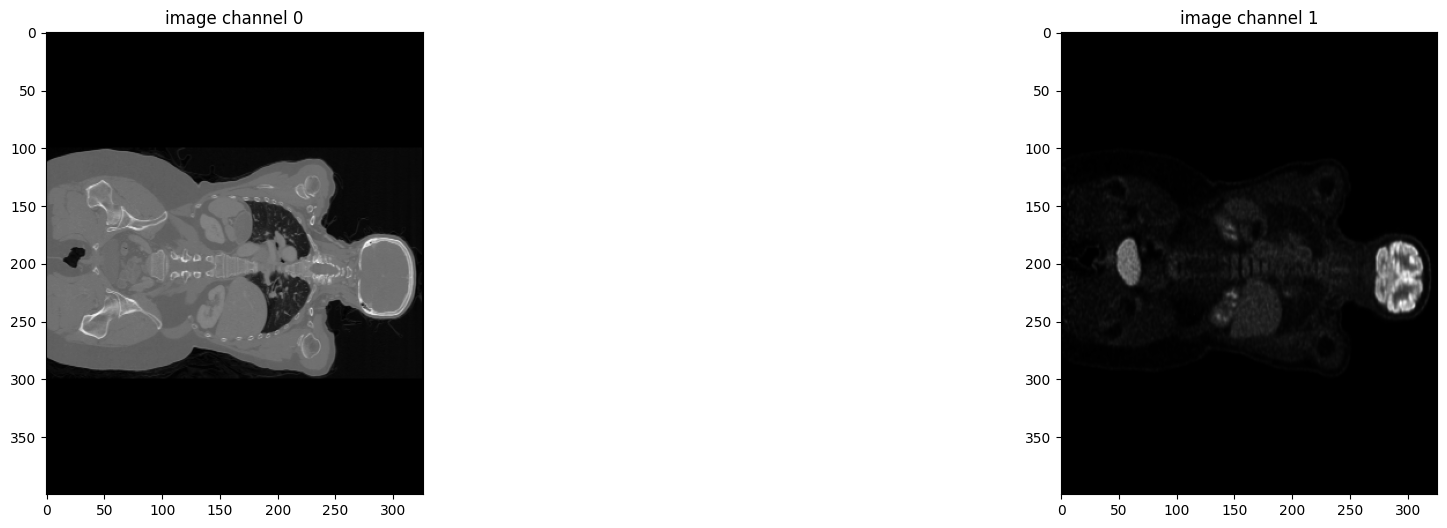

label shape: torch.Size([400, 400, 326])


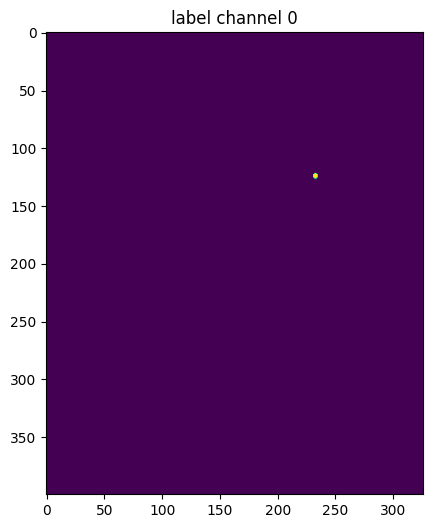

In [4]:
val_data_example = Orientationd(keys=["image", "label"], axcodes="RAS")(data_d)
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, 180  ,:].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][:, 180  ,:].detach().cpu())
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

train, val, *_ = train_test_split(df, df['diagnosis'], test_size=0.3, stratify=df['diagnosis'], random_state=41)

In [6]:

print('__Train__')
print(f'{pd.concat([train.diagnosis.value_counts(normalize=True), train.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

print('\n')
print('__Validation__')
print(f'{pd.concat([val.diagnosis.value_counts(normalize=True), val.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

__Train__
                  %   |x|
diagnosis                
3          0.505871  1077
2          0.185533   395
0          0.165806   353
1          0.142790   304


__Validation__
                  %  |x|
diagnosis               
3          0.506024  462
2          0.185104  169
0          0.165389  151
1          0.143483  131


In [15]:
## Metric operation Test
import torch 
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from monai.transforms import (
                        Activations,
                        Compose,
                        AsDiscrete,
                        EnsureChannelFirstd
                    )
data_d = EnsureChannelFirstd(keys=['image','label'])(data_d)

In [80]:
dice_M = DiceMetric()
confusion_M = ConfusionMatrixMetric()  # ["miss_rate", "false_negative_rate", "fnr"] ["fall_out", "false_positive_rate", "fpr"]:

GT = torch.ones((1,1,1,3,3))
PRED = torch.rand((1,1,1,3,3))
converter = Compose(
    AsDiscrete(threshold=0.5)
)
print(PRED)
PRED = converter(PRED)
print(PRED)

PRED[0,0,0,0,0] = 0 
print(PRED)


# assert len(y.shape) == 5 and y.shape == y_pred.shape, 'for using DiceMetric func of monai, input tensors sholud be [B,C,H,W,(D)]'
dice_score = dice_M(y_pred=[PRED,PRED], y=[GT,GT]) # y_pred should be a binarized tensor.
print(dice_score)
# print(f'{dice_score.item()=}')

confusion_ret = confusion_M(y_pred=[PRED,PRED], y=[GT,GT])
tp, fp, tn, fn = confusion_ret[..., 0], confusion_ret[..., 1], confusion_ret[..., 2], confusion_ret[..., 3]
print(tp,fp,tn,fn)
print(f'False positive {fp}, False Negative {fn}')

print(f'False Positive Rate {fp / (fp+tn +1e-8)}')
print(f'False Negative Rate {fn / (fn+tp +1e-8)}')
# tensor([[[ 1.2990e+03, -4.0000e+00,  5.2159e+07,  0.0000e+00]]])

tensor([[[[[0.0910, 0.5809, 0.6075],
           [0.0174, 0.7982, 0.3734],
           [0.4459, 0.1106, 0.7088]]]]])
tensor([[[[[0., 1., 1.],
           [0., 1., 0.],
           [0., 0., 1.]]]]])
tensor([[[[[0., 1., 1.],
           [0., 1., 0.],
           [0., 0., 1.]]]]])
tensor([[0.6154],
        [0.6154]])
tensor([[4.],
        [4.]]) tensor([[0.],
        [0.]]) tensor([[0.],
        [0.]]) tensor([[5.],
        [5.]])
False positive tensor([[0.],
        [0.]]), False Negative tensor([[5.],
        [5.]])
False Positive Rate tensor([[0.],
        [0.]])
False Negative Rate tensor([[0.5556],
        [0.5556]])


In [36]:
print(y.shape)
print(y.unsqueeze(0).shape)

torch.Size([1, 400, 400, 326])
torch.Size([1, 1, 400, 400, 326])


In [37]:
y_pred = y = y.unsqueeze(0)
y = y.float()
y_pred = y_pred.float()

if y.shape != y_pred.shape:
    raise ValueError(f"y_pred and y should have same shapes, got {y_pred.shape} and {y.shape}.")

# reducing only spatial dimensions (not batch nor channels)
n_len = len(y_pred.shape)
reduce_axis = list(range(2, n_len))
print(reduce_axis)
intersection = torch.sum(y * y_pred, dim=reduce_axis)

y_o = torch.sum(y, reduce_axis)
y_pred_o = torch.sum(y_pred, dim=reduce_axis)
denominator = y_o + y_pred_o

torch.where(denominator > 0, (2.0 * intersection) / denominator, torch.tensor(1.0, device=y_o.device))

[2, 3, 4]


tensor([[1.]])